In [329]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.dummy import DummyRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
# Ajouter le modèle au pipeline final
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer

from sklearn import set_config
set_config(display='diagram')


#plot distribution de la target et voir le scaler à utiliser 
#np.set_printoptions(precision=2,linewidth=800,suppress=True)

In [330]:
#food_data = pd.read_csv('/content/drive/MyDrive/food_openfood.csv', sep='\t')
data_model =pd.read_csv('https://raw.githubusercontent.com/bachir151/stage/master/building_seattle.csv',on_bad_lines='skip')
data_model =data_model.drop(['Unnamed: 0'], axis=1)
data_model =data_model.drop(['index'], axis=1)

Séparation du jeu de données 

In [331]:
X= data_model[['NumberofBuildings','NumberofFloors',"BuildingType", 'ENERGYSTARScore','PropertyGFATotal','age_batiment','LargestPropertyUseType','PrimaryPropertyType','PropertyGFAParking']]
Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

In [332]:
numerical_features  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','ENERGYSTARScore','age_batiment','PropertyGFAParking']
categorical_features  = ['LargestPropertyUseType','PrimaryPropertyType',"BuildingType"]

### Passage au log pour notre varaible target TotalGHGEmissions

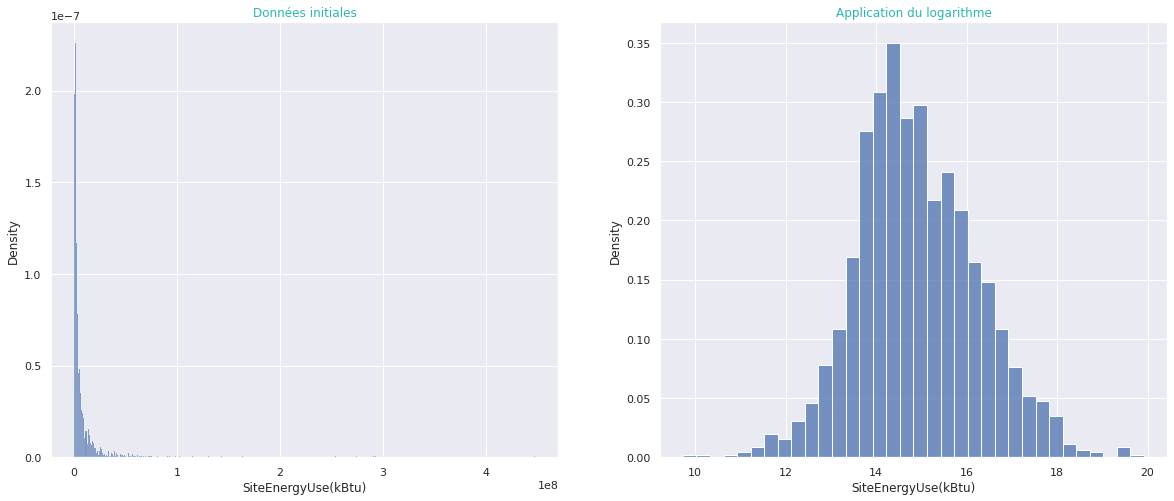

In [333]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

###Pipeline utilisé

In [334]:
import warnings
warnings.filterwarnings('ignore')

In [335]:
global  X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)


numerical_pipeline = Pipeline(steps=[
      #('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler())   
  ])
categorical_pipeline= Pipeline(steps=[
      #('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])


# Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne
preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline',numerical_pipeline,numerical_features),
      ('categorical_pipeline=',categorical_pipeline,categorical_features )
      ],
      #remainder='passthrough',
      n_jobs=-1,
      )



modèle baseline

In [336]:
cv = KFold(n_splits=4, shuffle=True, random_state=45)

model1= Pipeline(
    steps=[("preprocessor", preprocessor), ("regression", TransformedTargetRegressor(regressor=LinearRegression()  ,func=np.log, inverse_func=np.exp))]
)

score1 =cross_val_score(model1, X_train, Y_train['TotalGHGEmissions'], cv=cv)
#print(score1)

model2= Pipeline(
    steps=[("preprocessor", preprocessor), ("elasticnet", TransformedTargetRegressor(regressor=ElasticNet()  ,func=np.log, inverse_func=np.exp))]
)


score2 =cross_val_score(model2, X_train, Y_train['TotalGHGEmissions'], cv=cv)
#print(score2)

model3= Pipeline(
    steps=[("preprocessor", preprocessor), ("Linearsvr", TransformedTargetRegressor(regressor=LinearSVR()  ,func=np.log, inverse_func=np.exp))]
)


score3 =cross_val_score(model3, X_train, Y_train['TotalGHGEmissions'], cv=cv)
#print(score3)

model4= Pipeline(
    steps=[("preprocessor", preprocessor), ("randomforest", TransformedTargetRegressor(regressor=RandomForestRegressor(),func=np.log, inverse_func=np.exp))]
)


r2 = make_scorer(r2_score)
score4=cross_val_score(model4, X_train, Y_train['TotalGHGEmissions'], cv=cv,scoring=r2)
print("modèle 4",score4.mean())

model5= Pipeline(
    steps=[("preprocessor", preprocessor), ("xgboost", TransformedTargetRegressor(regressor=xgb.XGBRegressor()  ,func=np.log, inverse_func=np.exp))]
)

r2 = make_scorer(r2_score)
score5=cross_val_score(model5, X_train, Y_train['TotalGHGEmissions'], cv=cv,scoring=r2)
print("modèle 5",score5.mean())

dico_results ={}

dico_results["reg"] = score1
dico_results["Elastic"] = score2
dico_results["LinearSVR"] = score3
dico_results["Randomforest"] = score4
dico_results["Xgboost"] = score5

modèle 4 0.2912009750860509
[14:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
modèle 5 0.27829928681568683


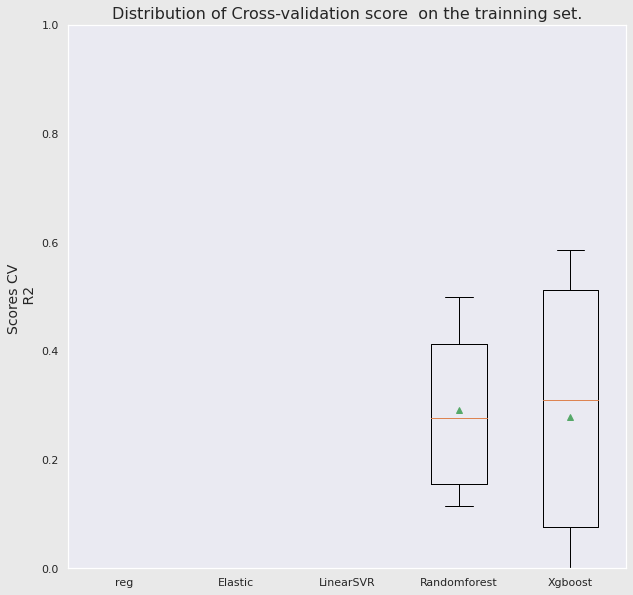

In [337]:
#sns.set(rc={'figure.figsize':(20.7,10.27)})
fig=plt.figure(figsize=[10,10])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("Distribution of Cross-validation score  on the trainning set.",size=16)
plt.boxplot(dico_results.values(),labels=dico_results.keys(),showmeans=True)
plt.ylabel("Scores CV \n R2",size=14)
plt.ylim(0,1)
plt.grid()

Entraînement des modèles 

In [338]:
model1.fit (X_train,Y_train['TotalGHGEmissions'])
model2.fit (X_train,Y_train['TotalGHGEmissions'])
model3.fit (X_train,Y_train['TotalGHGEmissions'])
model4.fit (X_train,Y_train['TotalGHGEmissions'])
model5.fit (X_train,Y_train['TotalGHGEmissions'])

[14:17:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'ENERGYSTARScore',
                                                   'age_batiment',
                                                   'PropertyGFAParking']),
                                                 ('categorical_pipeline=',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder())]),
                                                  ['LargestPropertyUseType',
                                                   'PrimaryPropertyType',
                                                   'BuildingType'])])),
                ('xgboost',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=XGBRegressor()))])

### Fonction d'affichage des différents métriques 

In [339]:
def metrics_baseModel(model, variable_target) :
  y_train_predict = model.predict(X_train)
  rmse = (mean_absolute_error(Y_train[variable_target], y_train_predict))
  r2 = r2_score(Y_train[variable_target], y_train_predict)
  
  print('La performance du modèle sur la base dapprentissage')
  #print('--------------------------------------------------')
  print('MAE : {}'.format(rmse))
  #print(f'MSE : {mean_squared_error(Y_train['TotalGHGEmissions'], y_train_predict)}')
  print('le score R2 est : {}'.format(r2))
  print('\n')
  
  # model evaluation for testing set
  y_test_predict = model.predict(X_test)
  rmse = (mean_absolute_error(Y_test[variable_target], y_test_predict))
  r2 = r2_score(Y_test[variable_target], y_test_predict)
  
  print('La performance du modèle sur la base de test')
  #print('------------------------------------------------------')
  print('MAE: {}'.format(rmse))
  print('le score R2 est : {}'.format(r2))
  print('\n')

### On utilise deux métriques pour l’évaluation L’erreur absolue moyenne et le R-square (la qualité du modèle de régression)

In [340]:
print("                     Regression                   \n")

metrics_baseModel(model1,'TotalGHGEmissions')

print("                     ElasticNet                        \n")

metrics_baseModel(model2,'TotalGHGEmissions')

print("           LinearSVR                                 \n")

metrics_baseModel(model3,'TotalGHGEmissions')

print("                         RandomForest                 \n")

metrics_baseModel(model4,'TotalGHGEmissions')

print("                 Xgboost                          \n")

metrics_baseModel(model5,'TotalGHGEmissions')

                     Regression                   

La performance du modèle sur la base dapprentissage
MAE : 287.5243373051869
le score R2 est : -32.17704916556638


La performance du modèle sur la base de test
MAE: 150.27669936557788
le score R2 est : -2.5013378212275184


                     ElasticNet                        

La performance du modèle sur la base dapprentissage
MAE : 164.84728653715675
le score R2 est : -0.015529802083845023


La performance du modèle sur la base de test
MAE: 130.72114818828658
le score R2 est : -0.03842167833804622


           LinearSVR                                 

La performance du modèle sur la base dapprentissage
MAE : 876.350529288126
le score R2 est : -869.0190270360532


La performance du modèle sur la base de test
MAE: 166.09239356855437
le score R2 est : -4.62671631983109


                         RandomForest                 

La performance du modèle sur la base dapprentissage
MAE : 64.45891277526061
le score R2 est : 0.6588681357

##Qualité prédiction sur la base test du meilleur modèle.

In [341]:
y_test = Y_test['TotalGHGEmissions']
y_pred= model4.predict(X_test)
#print(model4.score(X_test,y_test))

print("score de la prédiction:\n")#, accuracy_score(y_test, y_pred)), 
print("MAE = ",mean_absolute_error(y_test,y_pred))
print("R2= ",r2_score(y_test,y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))


score de la prédiction:

MAE =  97.75861690657645
R2=  0.4684385936631976
RMSE =  317.2353565116771
median abs err =  27.683659591992104


Valeurs prédites vs valeurs réelles du meilleur modèle

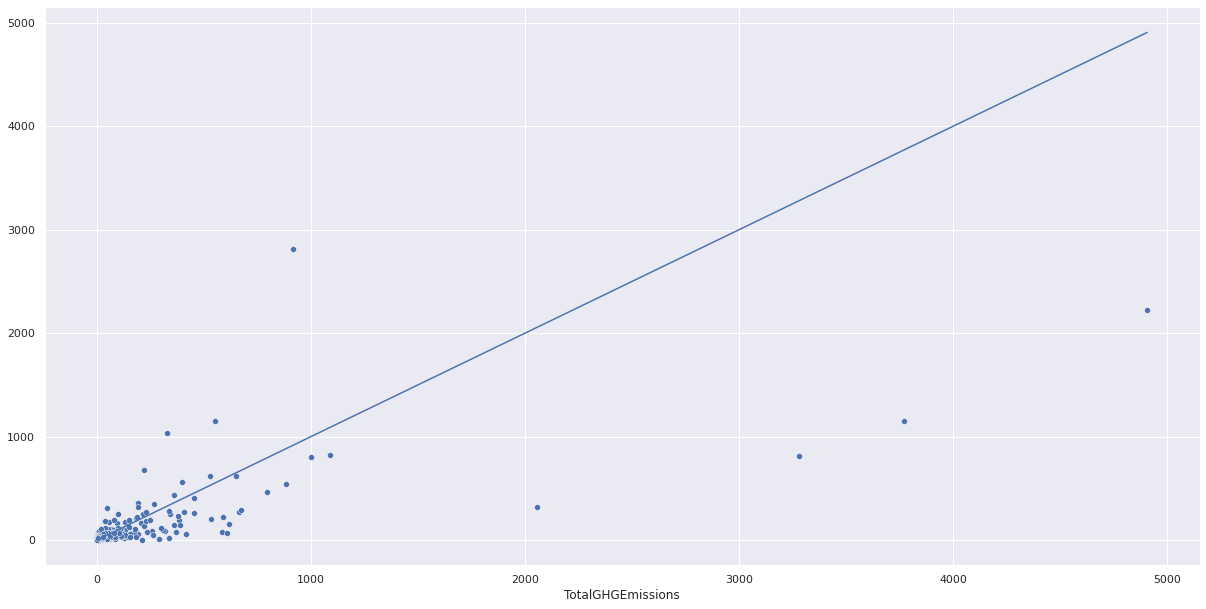

In [342]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
sns.scatterplot(x=y_test, y=y_pred)

### Code feature name

In [343]:
# Code copié à partir du site : https://bbakiu.medium.com/extracting-feature-names-from-the-columntransformer-f1bed520aeba
import warnings

from sklearn.pipeline import Pipeline

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    
    # Get columns and bin edges
    def pair_bin_edges_columns(bins_edges, columns):
        all_edge_column = []
        for index in range(len(columns)):
            bin_edge = bins_edges[index]
            column = columns[index]
            
            pair_bin_edge = []
            # match consecutive bin edges together
            for first, second in zip(bin_edge, bin_edge[1:]):
                pair_bin_edge.append((first, second))
            
            bin_edge_column = [column +": ["+ str(edge[0]) +", "+ str(edge[1])+")"  for edge in pair_bin_edge]
            all_edge_column.extend(bin_edge_column)
        return all_edge_column
    
    
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            
            # For transformers that create bins
            if hasattr(trans, 'bin_edges_'):
                bins_edges = trans.bin_edges_
                pairs_edges_columns = pair_bin_edges_columns(bins_edges, column)
            if column is None:
                return []
            else:
                return [name + "__" + f for f in pairs_edges_columns]
        return [name + "__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

### Features importance

In [344]:
#Poids de chaque feature dans le modèle
feature_importance_value=model4.named_steps['randomforest'].regressor_.feature_importances_ 

#Noms de features utilisés dans le modèle
feature_names = get_feature_names(preprocessor)

#Dataframe regroupant les features et leur poids
feat_importances = pd.Series(feature_importance_value , index=feature_names)

In [345]:
#Création et transposition de la dataframe feature importance
feat_importances = pd.DataFrame(feat_importances).transpose()

#Agrégation des features par appartenance à une catégorie
feat_importances['LargestPropertyUseType']= feat_importances[list(feat_importances.filter(regex='one-hot__x0'))].sum(axis=1)
feat_importances['PrimaryPropertyType']= feat_importances[list(feat_importances.filter(regex='one-hot__x1'))].sum(axis=1)
feat_importances["BuildingType"]= feat_importances[list(feat_importances.filter(regex='one-hot__x2'))].sum(axis=1)

# Colonnes à supprimer 
unwanted = feat_importances.columns[feat_importances.columns.str.startswith('one-hot__x')]
feat_importances.drop(unwanted, axis=1, inplace=True)

#On ramène la dataFrame à sa forme initiale
feat_importances = pd.DataFrame(feat_importances).transpose()

#On renomme et reformate les valeurs de la colonne feature
df1=feat_importances.reset_index().rename(columns={"index": "features", 0: "poids"})
df1['features']=df1['features'].str.replace('numerical_pipeline__','')


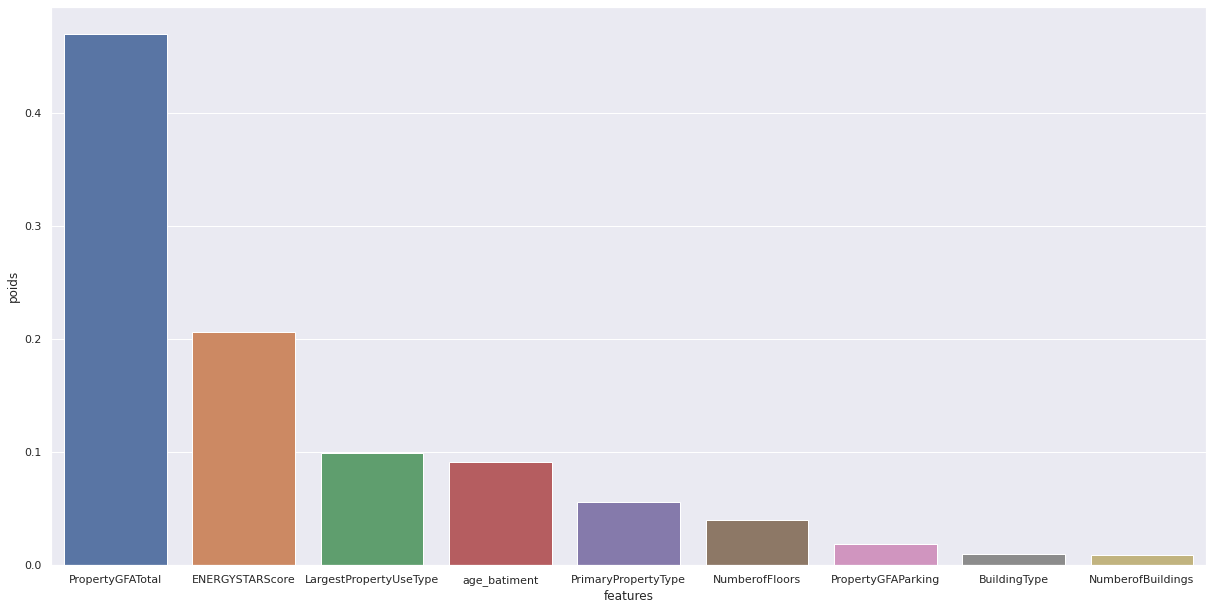

In [346]:
#On trace le graphique du feature importance 
sns.barplot(x='features', y='poids', data=df1.sort_values(by='poids', ascending=False))

### GridSearch

Pipeline, paramètre  et Gridsearch de tous les modèles à tester 

In [347]:
#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
nb_split = 5

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp) )]
)

myscore = ('r2','neg_mean_absolute_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 

score = ['accuracy','neg_mean_absolute_error']
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore,
        cv=nb_split,return_train_score=True)


tt = TransformedTargetRegressor(regressor=lr_grid_search ,
                                 func=np.log, inverse_func=np.exp)

#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)

elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-4, 0, num=5),
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   

elastic_grid_search = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ]    
lsvr_grid_search = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)

# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [5, 15, 25, 100],
                   'RFR__regressor__min_samples_split': [2, 5, 10],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5,10]}
                                                    ]  
rfr_grid_search = GridSearchCV(estimator=pipe_rfr,
        param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)                                                  
                                                 
# Rajouter une métrique pour GridSearch
# Xgboost Regressor
pipe_xgbr = Pipeline(
    steps=[("preprocessor", preprocessor), ("xgbr", xgb.XGBRegressor(tree_method='gpu_hist'))]
)


"""xgbr_param_grid = [ {'xgbr__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
                          'xgbr__gamma': [0, 0.25, 0.5, 1.0],
                           'xgbr__max_depth': [6, 10, 15, 20],
                          'xgbr__min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
                          'xgbr__n_estimators': [25, 50, 100, 500, 1000]}  ]   """


grid_result = lr_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LR__regressor__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,0.032694,0.005820,0.020017,0.001317,True,{'LR__regressor__fit_intercept': True},-20132.915959,0.277223,-2.11309,0.383397,...,-887.705812,1415.513870,1,-216.312129,-219.293342,-294.778397,-252.92929,-310.168814,-258.696394,38.297799
1,0.041448,0.016993,0.020708,0.002668,False,{'LR__regressor__fit_intercept': False},-20132.915959,0.276174,-2.11309,0.380899,...,-887.751561,1415.490544,2,-216.312129,-218.991523,-294.778397,-253.23389,-310.168814,-258.696951,38.351174


Entrainement des modèles et choix des meilleurs modèles

In [348]:
import warnings
warnings.filterwarnings('ignore')

global target
global lr_grid_search_model , elastic_grid_search_model, lsvr_grid_search_model, rfr_grid_search_model 

target = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

In [349]:
target_x =target[0]
lr_grid_search_model = lr_grid_search.fit(X_train,Y_train[target_x])
elastic_grid_search_model = elastic_grid_search.fit(X_train,Y_train[target_x])
lsvr_grid_search_model = lsvr_grid_search.fit(X_train,Y_train[target_x])
rfr_grid_search_model = rfr_grid_search.fit(X_train,Y_train[target_x])

## <ins> Choix du modèle pour la variable target 'TotalGHGEmissions' </ins>

In [350]:
a=pd.DataFrame(lr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
b=pd.DataFrame(elastic_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
c=pd.DataFrame(lsvr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
d=pd.DataFrame(rfr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
R=pd.concat([a, b,c,d])
R["Modèles"] = ['LinearRegression', 'ElasticNet', 'SVR', 'RandomForest']
R

,params,mean_fit_time,mean_test_neg_mean_absolute_error,mean_test_r2,std_train_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,Modèles
0,{'LR__regressor__fit_intercept': True},0.035582,-887.705812,-4027.417557,38.297799,1,LinearRegression
132,"{'ELN__regressor__alpha': 1.0, 'ELN__regressor...",0.037485,-157.227705,0.012365,7.931099,1,ElasticNet
85,"{'LSVR__regressor__C': 0.01, 'LSVR__regressor_...",0.029805,-146.060633,0.126451,8.342067,1,SVR
132,"{'RFR__regressor__bootstrap': False, 'RFR__reg...",0.212743,-122.324597,0.399443,1.525114,1,RandomForest


Avec la graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur score **MAE** (=-133) et un meilleur $R^2$ (=0.4) . On rentiendra ce modèle pour la modélisation de la 
variable **TotalGHGEmissions** est donc le modèle RandomForestRegressor.

Score model sur le jeu de test 

In [351]:
y_pred = rfr_grid_search_model.best_estimator_.predict(X_test)

print("RMSE = ", round(np.sqrt(mean_squared_error(Y_test['TotalGHGEmissions'],y_pred)) ,2))

print("MAE = ",round((mean_absolute_error(Y_test['TotalGHGEmissions'],y_pred)),2) )

print("R2 = ",round((r2_score(Y_test['TotalGHGEmissions'],y_pred)),2))

RMSE =  351.62
MAE =  96.82
R2 =  0.35


Temps d'entrainement des modèles

In [166]:
import plotly.graph_objects as go
fig = go.Figure([ go.Bar(name='temps entrainement',x=R['Modèles'], y=R['mean_fit_time'])])
fig.update_layout(barmode='group')

fig.show()

Observons les scores obtenus sur les différents splits de la Cross-validation :

### Code

In [176]:
import plotly.express as px
def trace_mae() :
  nb_split = 5
  t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error",	"split4_train_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error","split4_train_neg_mean_absolute_error"]]
  t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"]]

  df1_transposed = t1.T
  df1_transposed 
  df2_transposed = t2.T
  final=pd.concat ([df1_transposed,df2_transposed ])
  final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
  final.rename(columns={0: "MAE"}, inplace=True)
  final=final.reset_index()
  final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
  final

  fig = px.line( final, x='Split_cross validation',y='MAE', color='color', symbol="color")
  fig.show()

def trace_r2() :
    nb_split = 5
    t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2",	"split4_train_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2","split4_train_r2"]]
    t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"]]

    df1_transposed = t1.T
    df1_transposed 
    df2_transposed = t2.T
    final=pd.concat ([df1_transposed,df2_transposed ])
    final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
    final.rename(columns={0: "R2"}, inplace=True)
    final=final.reset_index()
    final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
    final

    fig = px.line( final, x='Split_cross validation',y='R2', color='color', symbol="color")
    fig.show()



### Performance de notre modèle selectionné dans le train et le test set de  chaque split de la crossvalidation.

In [177]:
trace_mae()
trace_r2()

On voit bien ici que la performance du modèle sur les données se rapproche de celle sur les données de test. On peut ne pas envisager un overffiting de notre modèle séléctionné.

### Score de notre modèle  sur le test set 

In [179]:
from sklearn.metrics import median_absolute_error, r2_score
y_test_predict = rfr_grid_search_model.predict(X_test)
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MAE": f"{mean_absolute_error(y_true, y_pred):.3f}",
    }
print(compute_score(Y_test[target[0]], y_test_predict ) ) 

{'R2': '0.352', 'MAE': '100.100'}


Sur le test set Le MAE du modèle s'est amélioré tandis que son $R^2$.

Valeurs prédites vs valeurs réelles

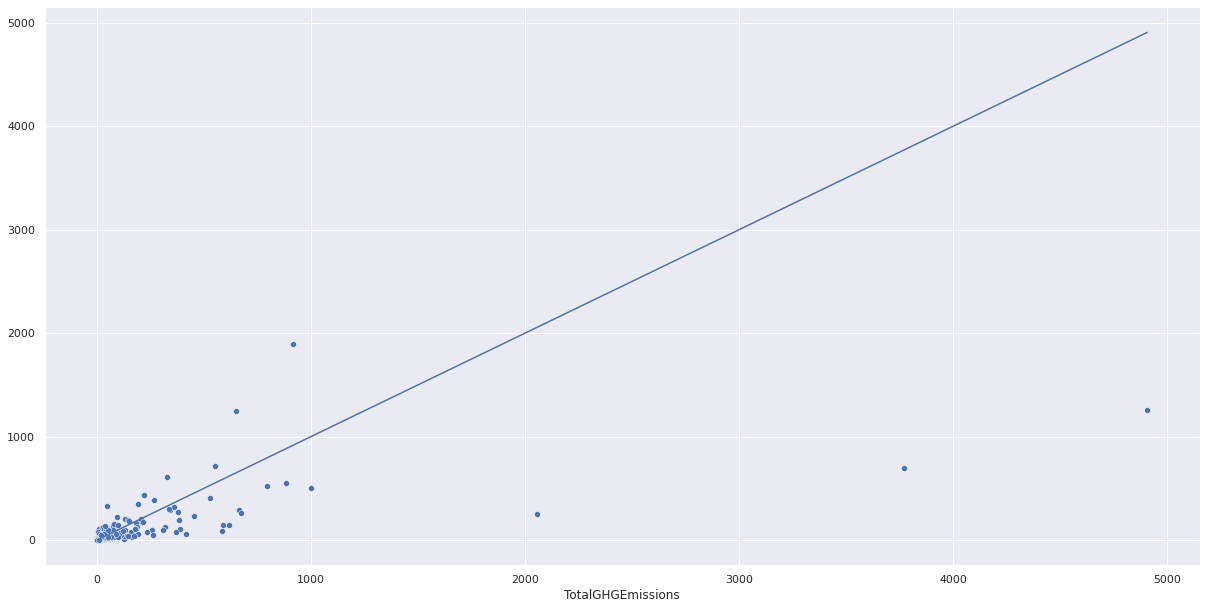

In [171]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
p1 = max(max(y_test), max(y_test_predict))
p2 = min(min(y_test), min(y_test_predict))
plt.plot([p1, p2], [p1, p2], 'b-')
sns.scatterplot(x=Y_test[target[0]], y=y_test_predict)

Ici, le modèle est n'est pas très bien ajusté aux données. 